<a href="https://colab.research.google.com/github/YusukeAoki57/diveintocode-ml/blob/master/sprint7_%E3%82%AF%E3%83%A9%E3%82%B9%E3%82%BF%E3%83%AA%E3%83%B3%E3%82%B0_ipynb_%E3%81%AE%E3%82%B3%E3%83%94%E3%83%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#方針
#①サンプルのインデックス毎にkクラス分のラベルをランダムに割り当てる
#②各ラベル毎にデータをグルーピングし、クラスタを生成
#③各クラスタでデータ点の平均値を求め重心とする
#④その重心から、全てのサンプルとの距離を算出する
#⑤各重心との距離が近い方のクラスタを割り当て直す
#⑥SSEを計算しておく
#⑦③～⑥を繰り返す
#⑧SSEがほぼ下がらなくなることを確認し、実行終了する

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
iris=load_iris()
iris_data=pd.DataFrame(iris.data,columns=iris.feature_names)
print(iris_data)

     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                  5.1               3.5                1.4               0.2
1                  4.9               3.0                1.4               0.2
2                  4.7               3.2                1.3               0.2
3                  4.6               3.1                1.5               0.2
4                  5.0               3.6                1.4               0.2
..                 ...               ...                ...               ...
145                6.7               3.0                5.2               2.3
146                6.3               2.5                5.0               1.9
147                6.5               3.0                5.2               2.0
148                6.2               3.4                5.4               2.3
149                5.9               3.0                5.1               1.8

[150 rows x 4 columns]


In [4]:
#targetの生成
all_y=pd.DataFrame(iris.target)
all_y.columns=['Species']

#特徴量との結合
all_xy=pd.merge(iris_data,all_y,left_index=True, right_index=True)

part_columns=all_xy[all_xy['Species'] != 0]
print(part_columns)

#sepal_lengthとpetal_lengthのみのデータの生成
part_all1=part_columns.drop('sepal width (cm)', axis=1)
part_all=part_all1.drop('petal width (cm)', axis=1)

     sepal length (cm)  sepal width (cm)  ...  petal width (cm)  Species
50                 7.0               3.2  ...               1.4        1
51                 6.4               3.2  ...               1.5        1
52                 6.9               3.1  ...               1.5        1
53                 5.5               2.3  ...               1.3        1
54                 6.5               2.8  ...               1.5        1
..                 ...               ...  ...               ...      ...
145                6.7               3.0  ...               2.3        2
146                6.3               2.5  ...               1.9        2
147                6.5               3.0  ...               2.0        2
148                6.2               3.4  ...               2.3        2
149                5.9               3.0  ...               1.8        2

[100 rows x 5 columns]


In [5]:
#numpyに変換
x=part_all.drop('Species', axis=1).values
y=part_all.iloc[:,-1].values

#分割 4特徴量
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)


In [6]:
class ScratchKMeans():
    """
    K-meansのスクラッチ実装
    Parameters
    ----------
    n_clusters : int
      クラスタ数
    n_init : int
      中心点の初期値を何回変えて計算するか
    max_iter : int
      1回の計算で最大何イテレーションするか
    tol : float
      イテレーションを終了する基準となる中心点と重心の許容誤差
    verbose : bool
      学習過程を出力する場合はTrue
    """
    def __init__(self, n_clusters=4, n_init=3, max_iter=10, tol=0.5, verbose=False):
        # ハイパーパラメータを属性として記録
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose
        self.min_idx=None
    def _center(self,X,k1):
        #データの平均値を取り重心を求める
        if self.min_idx is None:
          k=k1
        else:
          k=self.min_idx
        #print(k)
        cls=np.unique(k)
        self.c=np.zeros((self.n_clusters,X.shape[1]))
        for j in range((X.shape[1])):
          for i in cls:
            c=X[k[:,-1]==i] #(x,j)
            self.c[i][j]=c[:,j].mean(axis=0)
        #print(self.c)
        return self.c 
    def _distance(self,X,k1):
        #あるデータ点に対して全ての重心からの距離を算出し、最も距離が小さい時の重心をその点のラベルとする
        c=self._center(X,k1)
        dis=np.zeros((X.shape[0],self.n_clusters))
        for j in range(X.shape[0]):
          for i in range(len(c)):
            u=X[j,:]-c[i,:] #(1,j)-(1,j)=(1,j)
            dis[j][i]=np.linalg.norm(u) #(n,k)
        self.min_idx=np.argmin(dis,axis=1) #(n,1) 最小値のインデックスを返す
        self.min_idx=self.min_idx.reshape(self.min_idx.shape[0],1)
        min_dis=np.min(dis,axis=1) 
        #print(min_dis)
        return min_dis
    def _SSE(self,X,k1):
        min_dis=self._distance(X,k1)
        min_dis_2=min_dis**2
        SSE=np.sum(min_dis_2,axis=0) #(1,1)
        return SSE
    def _control(self,X,k1):
      SSE=[]
      for i in range(self.max_iter):
        s=self._SSE(X,k1)
        SSE.append(s)   
      SSE2=np.array(SSE)
      #print(SSE2)
      return SSE2

    def fit(self, X):
        """
        K-meansによるクラスタリングを計算
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        """
        SSE_min=100
        #ランダムのラベルを生成
        for i in range(self.n_init):
          k=np.random.randint(0, self.n_clusters,X.shape[0])
          self.k1=k.reshape(k.shape[0],1)
        #ラベルをxに結合
          SSE=self._control(X,self.k1)
          if SSE_min>SSE[-1]:
            SSE_min=SSE[-1]
            self.c=self.c       
        return SSE_min
    def predict(self, X):
        c=self.c
        dis=np.zeros((X.shape[0],self.n_clusters))
        for j in range(X.shape[0]):
          for i in range(len(c)):
            u=X[j,:]-c[i,:] #(1,j)-(1,j)=(1,j)
            dis[j][i]=np.linalg.norm(u) #(n,k)
        min_idx=np.argmin(dis,axis=1) #(n,1) 最小値のインデックスを返す
        min_idx=min_idx.reshape(min_idx.shape[0],1)
        return min_idx





In [7]:
cls=ScratchKMeans(n_clusters=100)
cls.fit(x_train)

0.5841666666666664

In [8]:
y_pred=cls.predict(x_test)
y_pred

array([[97],
       [15],
       [92],
       [21],
       [ 0],
       [47],
       [27],
       [10],
       [47],
       [39],
       [15],
       [69],
       [15],
       [67],
       [54],
       [80],
       [10],
       [38],
       [95],
       [26],
       [54],
       [61],
       [79],
       [85],
       [41]])

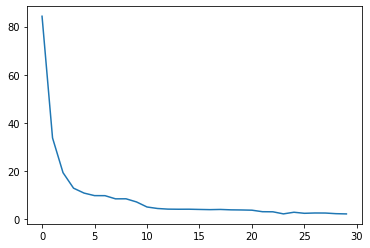

In [9]:
#エルボー法

SSE=[]
num=[]
n_clusters=30
for i in range(n_clusters):
  cls=ScratchKMeans(n_clusters=i+1)
  SSE.append(cls.fit(x_train))
  num.append(i)
SSE2=np.array(SSE)
x=num
y=SSE2
plt.plot(x, y, linestyle="solid")


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
import pandas as pd 
train_a= pd.read_csv('drive/My Drive/DIVE INTO CODE/0_課題/2月/0_week4/Wholesale customers data.csv',dtype = None)
print(train_a)

     Channel  Region  Fresh  ...  Frozen  Detergents_Paper  Delicassen
0          2       3  12669  ...     214              2674        1338
1          2       3   7057  ...    1762              3293        1776
2          2       3   6353  ...    2405              3516        7844
3          1       3  13265  ...    6404               507        1788
4          2       3  22615  ...    3915              1777        5185
..       ...     ...    ...  ...     ...               ...         ...
435        1       3  29703  ...   13135               182        2204
436        1       3  39228  ...    4510                93        2346
437        2       3  14531  ...     437             14841        1867
438        1       3  10290  ...    1038               168        2125
439        1       3   2787  ...      65               477          52

[440 rows x 8 columns]


In [25]:
train = train_a.drop('Region',axis=1)
train=train.drop('Channel',axis=1)
print(train)

     Fresh   Milk  Grocery  Frozen  Detergents_Paper  Delicassen
0    12669   9656     7561     214              2674        1338
1     7057   9810     9568    1762              3293        1776
2     6353   8808     7684    2405              3516        7844
3    13265   1196     4221    6404               507        1788
4    22615   5410     7198    3915              1777        5185
..     ...    ...      ...     ...               ...         ...
435  29703  12051    16027   13135               182        2204
436  39228   1431      764    4510                93        2346
437  14531  15488    30243     437             14841        1867
438  10290   1981     2232    1038               168        2125
439   2787   1698     2510      65               477          52

[440 rows x 6 columns]


In [13]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca = pca.fit(train)
data_pca = pca.transform(train)

[0.45961362 0.86478588 0.93481597 0.97883941 0.99386152 1.        ]


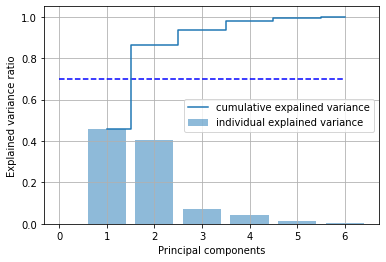

In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=None)
pca = pca.fit(train)
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)
print(cum_var_exp)
plt.bar(range(1,7), var_exp, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,7), cum_var_exp, where='mid', label='cumulative expalined variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.hlines(0.7, 0, 6,  "blue", linestyles='dashed')
plt.legend(loc='best')
plt.grid()
plt.show()

In [15]:
#最適なクラスタ数は5（上記エルボー法より）

In [18]:
x_train, x_test= train_test_split(data_pca, test_size=0.5, random_state=0)

In [21]:
cls2=ScratchKMeans(n_clusters=5)
cls2.fit(x_train)

100

In [23]:
y_pred2=cls2.predict(x_test)
y_pred2

array([[2],
       [4],
       [2],
       [4],
       [3],
       [3],
       [4],
       [1],
       [2],
       [2],
       [4],
       [4],
       [2],
       [3],
       [2],
       [2],
       [4],
       [2],
       [3],
       [1],
       [1],
       [4],
       [2],
       [2],
       [2],
       [2],
       [4],
       [3],
       [4],
       [1],
       [2],
       [4],
       [2],
       [2],
       [2],
       [0],
       [4],
       [2],
       [2],
       [2],
       [2],
       [1],
       [3],
       [4],
       [1],
       [2],
       [4],
       [2],
       [3],
       [3],
       [2],
       [2],
       [2],
       [4],
       [2],
       [3],
       [2],
       [3],
       [2],
       [3],
       [2],
       [4],
       [3],
       [4],
       [2],
       [2],
       [4],
       [3],
       [2],
       [4],
       [2],
       [3],
       [0],
       [3],
       [3],
       [3],
       [2],
       [2],
       [2],
       [1],
       [2],
       [2],
       [4],
    

In [28]:
train_a.iloc[:,0:2].values

array([[2, 3],
       [2, 3],
       [2, 3],
       [1, 3],
       [2, 3],
       [2, 3],
       [2, 3],
       [2, 3],
       [1, 3],
       [2, 3],
       [2, 3],
       [2, 3],
       [2, 3],
       [2, 3],
       [2, 3],
       [1, 3],
       [2, 3],
       [1, 3],
       [2, 3],
       [1, 3],
       [2, 3],
       [1, 3],
       [1, 3],
       [2, 3],
       [2, 3],
       [2, 3],
       [1, 3],
       [1, 3],
       [2, 3],
       [1, 3],
       [1, 3],
       [1, 3],
       [1, 3],
       [1, 3],
       [1, 3],
       [2, 3],
       [1, 3],
       [2, 3],
       [2, 3],
       [1, 3],
       [1, 3],
       [1, 3],
       [2, 3],
       [2, 3],
       [2, 3],
       [2, 3],
       [2, 3],
       [2, 3],
       [2, 3],
       [2, 3],
       [1, 3],
       [1, 3],
       [2, 3],
       [2, 3],
       [1, 3],
       [1, 3],
       [2, 3],
       [2, 3],
       [1, 3],
       [1, 3],
       [2, 3],
       [2, 3],
       [2, 3],
       [2, 3],
       [1, 3],
       [2, 3],
       [1,

In [29]:
#Channelは1と2のラベル、Regionは1,2,3のラベル、クラスタは1-5のラベルでそれぞれラベルの数が異なる

In [30]:
#6個の特徴量でクラスタリング

In [33]:
train=train_a.values
x_train, x_test= train_test_split(train, test_size=0.5, random_state=0)

In [41]:
cls3=ScratchKMeans(n_clusters=5)
cls3.fit(x_train)

100

In [42]:
y_pred3=cls3.predict(x_test)
y_pred3

array([[0],
       [4],
       [0],
       [4],
       [1],
       [1],
       [4],
       [2],
       [0],
       [0],
       [4],
       [4],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [2],
       [2],
       [4],
       [0],
       [0],
       [0],
       [0],
       [4],
       [1],
       [4],
       [2],
       [0],
       [4],
       [0],
       [0],
       [0],
       [4],
       [4],
       [0],
       [0],
       [0],
       [0],
       [2],
       [1],
       [4],
       [2],
       [0],
       [4],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [4],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [4],
       [0],
       [0],
       [4],
       [1],
       [0],
       [4],
       [0],
       [0],
       [3],
       [1],
       [1],
       [2],
       [0],
       [0],
       [0],
       [2],
       [0],
       [0],
       [4],
    

In [43]:
#卸売り業者にとっての有益な情報
#Regionが3の地区で最もChannelが多い